In [0]:
#https://www.tensorflow.org/tutorials/keras/overfit_and_underfit
#In this notebook, we'll explore several common regularization techniques, and use them to improve on a classification model.
#NOTE:
#BASICALLY HERE WE USED REGULARIZATION METHODS: DROPOUT AND REGULARIZERS TO IMPROVE LARGE COMPLEX MODELS OVERFITTING.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np

TensorFlow 2.x selected.


In [3]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt
import pathlib
import shutil
import tempfile


In [0]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


In [5]:
#Load the higgs dataset
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')


2816409600/2816407858 [==============================] - 132s 0us/step


In [0]:
FEATURES = 28


In [0]:
#The tf.data.experimental.CsvDataset class can be used to read csv records directly from a gzip file with no intermediate decompression step.
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")
#That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

#TensorFlow is most efficient when operating on large batches of data.
#So instead of repacking each row individually make a new Dataset that takes batches of 10000-examples, applies the pack_row function to each batch, and then splits the batches back up into individual records:
packed_ds = ds.batch(10000).map(pack_row).unbatch()


(1000, 28)
tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)
(28000,)


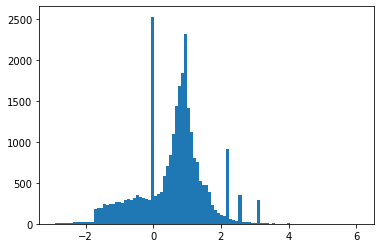

In [8]:
for features,label in packed_ds.batch(1000).take(1): #agarra cierta cantidad de valores
  print(features.shape)
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101) #separa los valores de los features, (que deberían de set 28*1000, por el flatten) en 101 bins
  print(features.numpy().flatten().shape) #Was right.


In [0]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE


In [0]:
#The Dataset.skip and Dataset.take methods make this easy.
#use the Dataset.cache method to ensure that the loader doesn't need to re-read the data form the file on each epoch:
#This are methods used to take data from this type of dataset, not sure how is this relevant, but im sure it is somehow.
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()


In [11]:
train_ds
#These datasets return individual examples. Use the .batch method to create batches of an appropriate size for training. Before batching also remember to .shuffle and .repeat the training set.

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [0]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)


In [0]:
#Many models train better if you gradually reduce the learning rate during training. 
#Use optimizers.schedules to reduce the learning rate over time:
#sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)



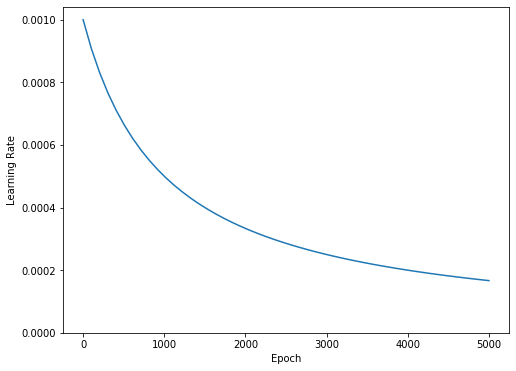

In [14]:
#mapping the leraning rate decay, we have not trained anything yet
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [0]:
  def get_callbacks(name):
    return [
      tfdocs.modeling.EpochDots(), #sets the verbose to be only every 100 epochs
      tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200), #sets to stop when the loss stops improving
      tf.keras.callbacks.TensorBoard(logdir/name), #saves metrics to analyze later
    ]


In [0]:
#Similarly each model will use the same Model.compile and Model.fit settings:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer() #calls function where we set to use the adam optimizer
  model.compile(optimizer=optimizer, #compile and set optimizer, loss and metrics
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])
  #Note: im not sure what compile is exactly, why do we need it?
  #The documentation literaly says: "Configures the model for training." https://www.tensorflow.org/api_docs/python/tf/keras/Model?version=stable
  model.summary()

  history = model.fit( #this is the fit, with the train data, epochs, validation(i think is the test), and callbacks (what are those https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback?version=stable)
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [17]:
#Now we make a tiny model:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)), #The input shape is 28, because the data is like that
    layers.Dense(1, activation='sigmoid')
])
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny') 
#I think we made the compile and fit to be able to pass various models to the same configuration without repeating ourselves

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4916,  binary_crossentropy:0.8258,  loss:0.8258,  val_accuracy:0.5110,  val_binary_crossentropy:0.7982,  val_loss:0.7982,  
....................................................................................................
Epoch: 100, accuracy:0.6521,  binary_crossentropy:0.6260,  loss:0.6260,  val_accuracy:0.6540,  val_binary_crossentropy:0.6212,  val_loss:0.6212,  
....................................................................................................
Epoch: 200, accuracy:0.66

(0.5, 0.7)

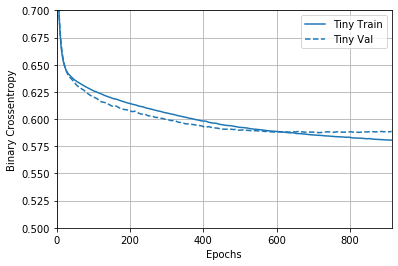

In [18]:
#Check how the model did:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])



In [0]:
#Now we make a small model
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])
#Remember this is to see how models can under and overfit

In [20]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4987,  binary_crossentropy:0.8763,  loss:0.8763,  val_accuracy:0.5480,  val_binary_crossentropy:0.7148,  val_loss:0.7148,  
....................................................................................................
Epoch: 100, accuracy:0.6505,  binary_crossentropy:0.6255,  loss:0.6255,  val_accuracy:0.6490,  val_binary_crossentropy:0.6234,  val_loss:0.

In [21]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5194,  binary_crossentropy:0.7036,  loss:0.7036,  val_accuracy:0.5440,  val_binary_crossentropy:0.6878,  val_loss:0.6878,  
....................................................................................................
E

In [22]:
#This one starts overfitting (it has the capacity to memorize the training data)
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])
size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5130,  binary_crossentropy:0.8404,  loss:0.8404,  val_accuracy:0.5740,  val_binary_crossentr

In [0]:
#@title Plot the training and validation losses
#(remember: a lower validation loss indicates a better model).
#While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.


Text(0.5, 0, 'Epochs [Log Scale]')

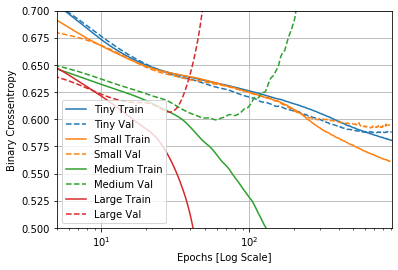

In [23]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")
#Not 100% sure what the dotted or solid line means
#I think the dotted is the error with the test set and the solid with the training one
#thats why large models go 'memorize' the train and loss is lower but it goes higher with the dotted line 


In [0]:
#@title View in TensorBoard
#These models all wrote TensorBoard logs during training.

In [25]:
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


In [0]:
#nice we can access the tensorboard.
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")


In [0]:
#@title Strategies to prevent overfitting


In [27]:
#Before getting into the content of this section copy the training logs from the "Tiny" model above, to use as a baseline for comparison.
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')


PosixPath('/tmp/tmpq7gzu74s/tensorboard_logs/regularizers/Tiny')

In [0]:
#I belive this just saves the data from 'Tiny' somewhere
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']


In [0]:
#A strategy is to Add weight regularization
#Usually a simple model is better than a complex one. (As long as it explains the relations in the data)
#A "simple model" in this context is a model where the distribution of parameter values has less entropy
"""
Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, 
which makes the distribution of weight values more "regular". This is called "weight regularization", 
and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:
    
    L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients 
      (i.e. to what is called the "L1 norm" of the weights).

    L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients 
      (i.e. to what is called the squared "L2 norm" of the weights). 
      L2 regularization is also called weight decay in the context of neural networks. 
      Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. 
L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.
In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. 
Let's add L2 weight regularization now.
"""
###text
soiasydkasjdhlqwiuhckasjhlkas = 1 #This is to stop the comment from printing

In [30]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001), #l2(0.001) means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value**2 to the total loss of the network.
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5086,  binary_crossentropy:0.8284,  loss:2.3472,  val_accuracy:0.5450,  val_binary_crossentr

(0.5, 0.7)

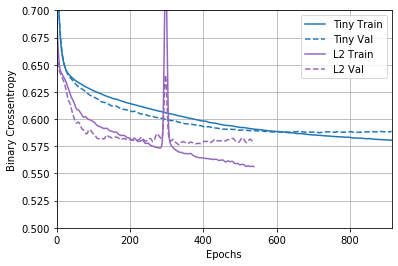

In [31]:
#So, that same "Large" model with an L2 regularization penalty performs much better:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])


In [0]:
#There are two important things to note about this sort of regularization.
#First: if you are writing your own training loop, then you need to be sure to ask the model for it's regularization losses.
result = l2_model(features)
regularization_loss = tf.add_n(l2_model.losses)
#Second: This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.
#There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay.
#This "Decoupled Weight Decay" Is seen in optimizers like optimizers.FTRL and optimizers.AdamW.


In [33]:
#We can also add dropout
#Dropout is one of the most effective and most commonly used regularization techniques for neural networks,
#Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. 
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

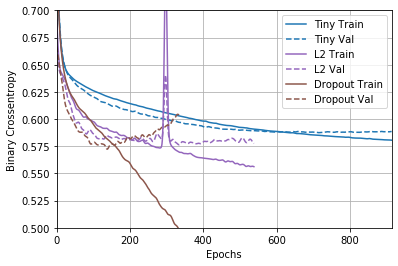

In [34]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])


In [35]:
#Combining dropout and regularizers
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

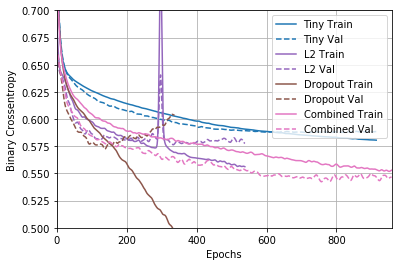

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])


In [37]:
%tensorboard --logdir {logdir}/regularizers


UsageError: Line magic function `%tensorboard` not found.


In [38]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


In [0]:
"""
Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

    Get more training data.
    Reduce the capacity of the network.
    Add weight regularization.
    Add dropout.

Two important approaches not covered in this guide are:

    data-augmentation
    batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.
"""